# Project 3 - Movie Review Sentiment Analysis
# STAT 542 Statistical Learning - Fall 2022

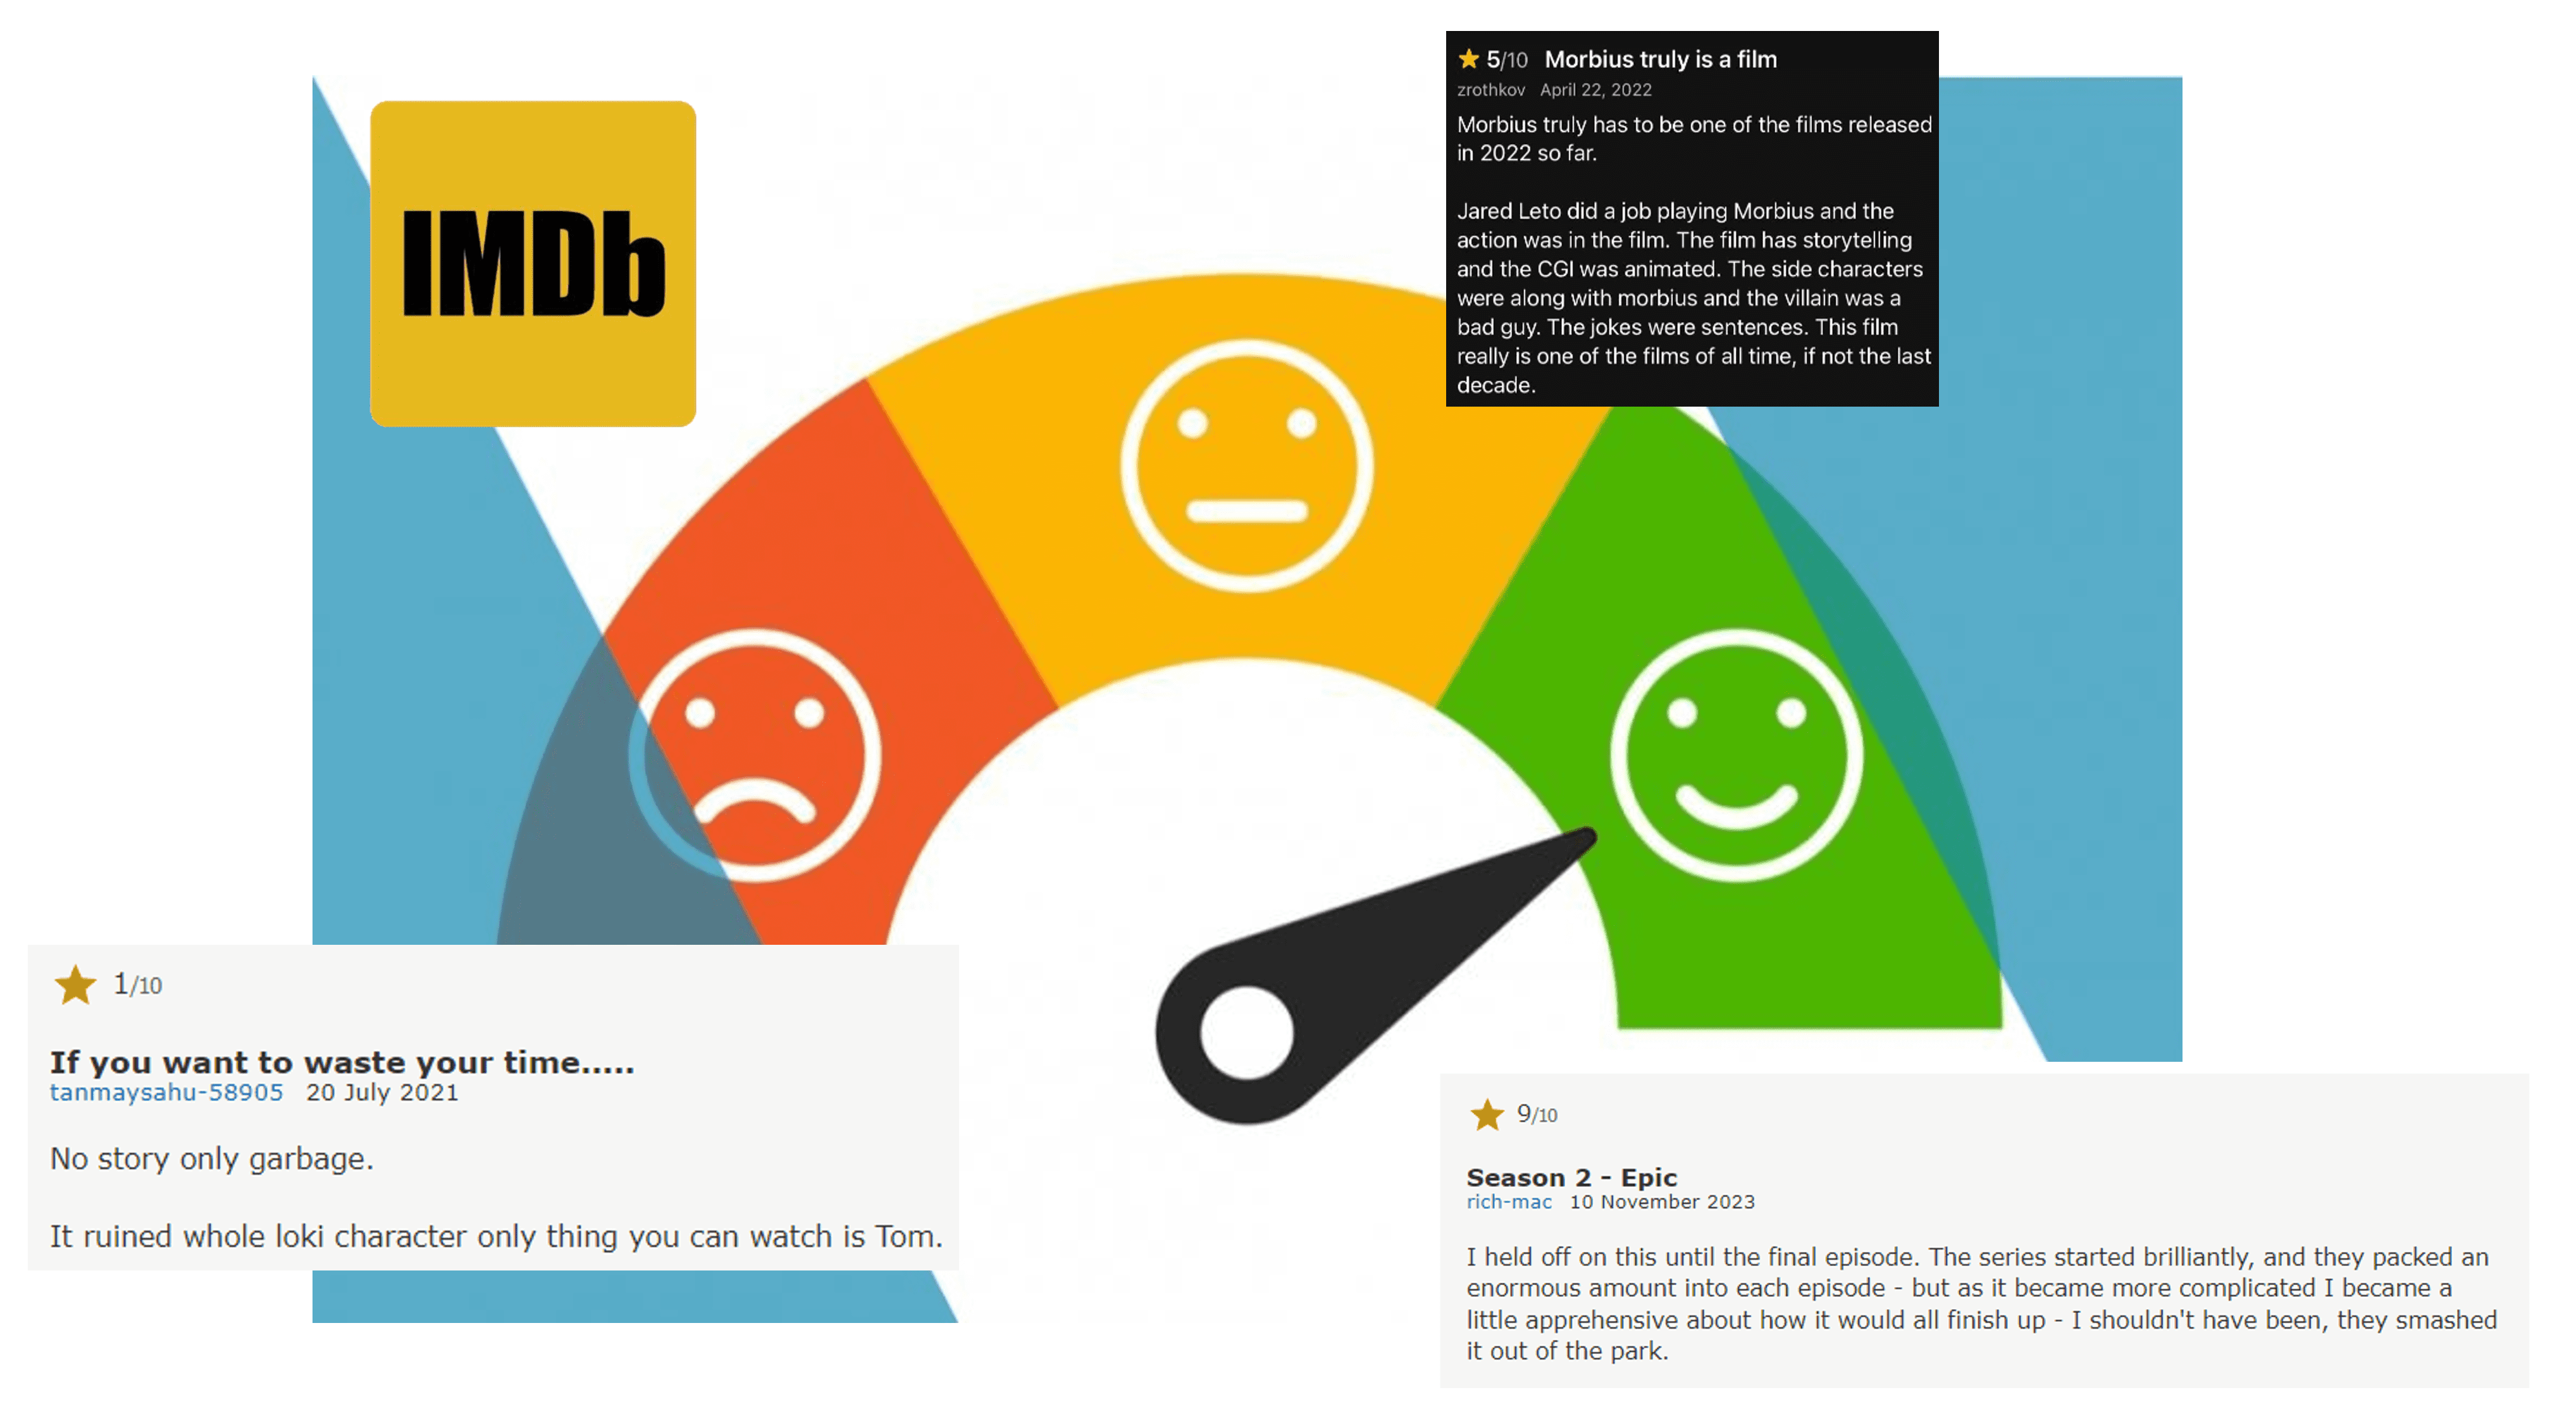

In [14]:
library("IRdisplay")
display_png(file="imdb.png", width=1000)  

## 1. Introduction

-  Sentiment analysis is a tool for classifying people's impression of a product or topic.
-  Using sentiment analysis, an algorithm can read a text written in natural language and map it to a scale ranging from positive to negative feelings.
-  Because it is able to interpret human language, sentiment analysis is widely used in many online platforms.
-  For instance, companies use sentiment analysis to gain direct feedback of customers of a product.

## 2. Overview of the project

- In this project, we create a sentiment analysis model to interpret movie reviews in the IMDB website.
- The data consists of 50000 reviews which have scores from 0 to 10.
- If the score is below or equal to 4, it is classified as negative. If the score is 7 or bigger, it is classified as positive (the reviews with scores of 5 and 6 are excluded from this analysis).
- The goal of the algorithm is to guess if the review is negative or positive directly from the text written by the reviewer.

## 3. Data processing

The data set, located in the file "alldata.tsv", is a table with 50000 rows and 4 columns. Each row represents a review, while the columns represent:

1. Id, the identification number of each review
    
2.  Sentiment, 0 for negative and 1 for positive
    
3. Score, from 0 to 10 and excluding 5 and 6.
    
4. Review, the actual text written by the reviewer.
    
The data processing consists of 2 main steps: (1) removing irrelevant symbols and (2) filtering the text using a vocabulary.

## 4. Model 

We use both R and Python to build our model. R is first used to identify the meaningful terms in the reviews. The vocabulary of extracted terms is then passed to Python to build the final model.

The detailed steps to build and test our classification model are:

1. Clean the data by removing punctuation marks and stop words.
    
2. From the cleaned reviews, build a vocabulary using all appearing N-grams terms, with N varying between 1 to 4 (individual words up to 4 sequential words).
    
3. Vectorize the reviews using Count Vectorization of the N-grams.

4. Reduce the size of the vocabulary to less than 1000 terms by using Logistic Regression with Lasso regularization **(main step done in R on this notebook)**.

5. Re-vectorize all reviews using the reduced vocabulary of N-grams found by Lasso.
    
6. Train a Neural Network by feeding the review vectors **(main step done in Python on the next notebook)**.

7. Evaluate the AUC of the Neural Network model on a test set.

In the next few sessions, the walk through all the computations done in this Project.


---


# Part I. Vocabulary Reduction using R

In [3]:
library("text2vec")
library("glmnet")

Loading required package: Matrix

Loaded glmnet 4.1-4



### Generating the vocabulary

First, we extract all data and take a look at it

In [4]:
train = read.table("alldata.tsv",
                   stringsAsFactors = FALSE,
                   header = TRUE)

head(train,n = 2L)

,id,sentiment,score,review
,<int>,<int>,<int>,<chr>
1,1,1,10,"Naturally in a film who's main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which anyone can enjoy. The pace is steady and constant, the characters full and engaging, the relationships and interactions natural showing that you do not need floods of tears to show emotion, screams to show fear, shouting to show dispute or violence to show anger. Naturally Joyce's short story lends the film a ready made structure as perfect as a polished diamond, but the small changes Huston makes such as the inclusion of the poem fit in neatly. It is truly a masterpiece of tact, subtlety and overwhelming beauty."
2,2,0,2,"This movie is a disaster within a disaster film. It is full of great action scenes, which are only meaningful if you throw away all sense of reality. Let's see, word to the wise, lava burns you; steam burns you. You can't stand next to lava. Diverting a minor lava flow is difficult, let alone a significant one. Scares me to think that some might actually believe what they saw in this movie.<br /><br />Even worse is the significant amount of talent that went into making this film. I mean the acting is actually very good. The effects are above average. Hard to believe somebody read the scripts for this and allowed all this talent to be wasted. I guess my suggestion would be that if this movie is about to start on TV ... look away! It is like a train wreck: it is so awful that once you know what is coming, you just have to watch. Look away and spend your time on more meaningful content."


Remove stop-words from the list given below

In [5]:
stop_words = c("i", "me", "my", "myself", 
               "we", "our", "ours", "ourselves", 
               "you", "your", "yours", 
               "their", "they", "his", "her", 
               "she", "he", "a", "an", "and",
               "is", "was", "are", "were", 
               "him", "himself", "has", "have", 
               "it", "its", "the", "us")

it_train = itoken(train$review,
                  preprocessor = tolower, 
                  tokenizer = word_tokenizer)

tmp.vocab = create_vocabulary(it_train, 
                              stopwords = stop_words, 
                              ngram = c(1L,4L))

tmp.vocab = prune_vocabulary(tmp.vocab, term_count_min = 10,
                             doc_proportion_max = 0.5,
                             doc_proportion_min = 0.001)

dtm_train = create_dtm(it_train, vocab_vectorizer(tmp.vocab))

as(<dgTMatrix>, "dgCMatrix") is deprecated since Matrix 1.5-0; do as(., "CsparseMatrix") instead



Now, use Logistic Regression with Lasso Regularization to reduce the number of words in the vocabulary

In [7]:
set.seed(3213)
tmpfit = glmnet(x = dtm_train, 
                y = train$sentiment, 
                alpha = 1,
                family='binomial')
print(tmpfit$df)

  [1]     0     1     2     3     4     4     6     7    11    15    18    22
 [13]    25    39    48    57    67    83    97   114   131   153   174   206
 [25]   238   270   303   338   389   437   489   561   643   740   859   982
 [37]  1126  1281  1471  1711  1962  2262  2585  2934  3273  3667  4087  4497
 [49]  4890  5321  5735  6158  6587  7018  7400  7747  8086  8447  8778  9054
 [61]  9376  9646  9886 10117 10354 10574 10760 10983 11150 11286 11421 11529
 [73] 11666 11776 11860 11965 12053 12142 12232 12352 12419 12495 12542 12594
 [85] 12631 12663 12705 12738 12776 12914 12882 12994 13038 13076 13115 13141
 [97] 13190 13212 13253 13270


Then, take the largest vocabulary size which is less than 2000 (position 41):

In [8]:
myvocab = colnames(dtm_train)[which(tmpfit$beta[, 41] != 0)]

Now, use this smaller vocabulary to run another Lasso step:

In [10]:
it_train = itoken(train$review,
                    preprocessor = tolower, 
                    tokenizer = word_tokenizer)

vectorizer = vocab_vectorizer(create_vocabulary(myvocab, 
                                                  ngram = c(1L, 2L)))
dtm_train = create_dtm(it_train, vectorizer)


set.seed(3213)
tmpfit = glmnet(x = dtm_train, 
                y = train$sentiment, 
                alpha = 1,
                family='binomial')
print(tmpfit$df)

 [1]    0    1    2    3    4    4    6    7   11   14   17   21   24   39   47
[16]   55   66   83   97  111  127  149  169  197  225  261  287  324  367  412
[31]  454  527  589  675  774  875 1005 1131 1287 1452 1572 1630 1659 1672 1682
[46] 1689 1693 1698 1699 1701 1703 1706 1709 1711 1715 1720 1722 1728 1731 1733
[61] 1736 1740 1740 1743 1743 1745 1746 1750 1750 1751 1754 1757 1758 1760 1763
[76] 1765 1767 1768 1769 1770 1770 1773 1773 1773 1776 1776 1777 1778 1778 1780
[91] 1782 1783 1783


Finally, we take the df closest to 1000 (position 37, df = 1005):

In [11]:
myvocab2 = colnames(dtm_train)[which(tmpfit$beta[, 37] != 0)]

Then, export the term in this vocabulary to csv:

In [12]:
write.csv(myvocab2, "myvocab2.csv")